In [15]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2
import imutils
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
import mahotas as mt
from scipy.fftpack import fft2, fftshift
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

# Features extraction

In [2]:
def sum_of_pixel(file_path):
    img = np.array(Image.open(file_path).convert('L'))
    return np.sum(img) / (img.shape[0] * img.shape[1])

In [3]:
def image_colorfulness(file_path):
    image = cv2.imread(file_path)
    image = imutils.resize(image, width=250)

    (B, G, R) = cv2.split(image.astype("float"))

    rg = np.absolute(R - G)

    yb = np.absolute(0.5 * (R + G) - B)

    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))

    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))

    return stdRoot + (0.3 * meanRoot)

In [4]:
def ngldm_features(file_path, radius=1, levels=256):
    image = imread(file_path, as_gray=True)

    image_normalized = (image - image.min()) / (image.max() - image.min()) * 255

    image_uint8 = image_normalized.astype(np.uint8)

    glcm = graycomatrix(image_uint8, distances=[radius], angles=[0], levels=levels,
                        symmetric=True, normed=True)

    ngldm_matrix = np.zeros((levels, levels), dtype=np.float64)

    for i in range(levels):
        for j in range(levels):
            ngldm_matrix[i, j] = np.sum(glcm[(i, j)])

    ngldm_matrix /= np.sum(ngldm_matrix)

    regularity = np.sum(ngldm_matrix ** 2)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    roughness = 1.0 / (1.0 + contrast)

    return regularity, roughness

In [5]:
def extract_features(file_path):
    image = cv2.imread(file_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = mt.features.haralick(gray)

    ht_mean = textures.mean(axis=0)
    return list(ht_mean)

In [6]:
def calculate_noise_level(image_path):
    # Load the image
    img = cv2.imread(image_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate standard deviation of pixel intensities
    noise_level = np.std(gray)
    return noise_level

In [14]:
def cfa_artifacts(image_path,  patch_size=128, frequency_range=(0.1, 0.5)):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Crop the image to the nearest multiple of patch size
    h, w = gray_img.shape
    h = h - (h % patch_size)
    w = w - (w % patch_size)
    gray_img = gray_img[:h, :w]

    # Compute the 2D Fourier transform of the image
    f_transform = fftshift(fft2(gray_img))

    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(f_transform)

    # Compute the power spectrum
    power_spectrum = np.abs(f_transform)**2

    # Define the frequency range of interest
    freq_min, freq_max = frequency_range
    freq_min_idx = int(power_spectrum.shape[0] * freq_min)
    freq_max_idx = int(power_spectrum.shape[0] * freq_max)

    # Calculate the sum of power within the frequency range
    power_within_range = np.sum(power_spectrum[freq_min_idx:freq_max_idx, freq_min_idx:freq_max_idx])

    # Normalize the sum by the total power in the spectrum
    total_power = np.sum(power_spectrum)
    cfa_metric = power_within_range / total_power

    return cfa_metric

In [8]:
def detect_editing_artifacts(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Calculate different features related to editing artifacts
    features = {}

    # detecting resampling artifacts
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    features['edge_density'] = edge_density

    # detecting blur inconsistencies
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    laplacian_var = cv2.Laplacian(blurred, cv2.CV_64F).var()
    features['laplacian_var'] = laplacian_var

    # detecting copy-move regions
    template = image[100:200, 100:200]  # Example region to search for duplicates
    res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    features['max_template_matching_score'] = max_val

    # Combine features into a single metric
    editing_artifacts_score = np.mean(list(features.values()))

    return editing_artifacts_score

# Load dataset

In [17]:
if os.path.exists('yanport_dataset/df_all_features.csv'):
    df = pd.read_csv('yanport_dataset/df_all_features.csv')
else: 
    if os.path.exists('yanport_dataset/df.csv'):
        df = pd.read_csv('yanport_dataset/df.csv')
    else:
        df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])

        folder_path = 'yanport_dataset/REAL'
        real_df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
                file_path = os.path.join(folder_path, filename)
                row = {'image_path': file_path, 'path_ela': 'yanport_dataset/ELA_REAL/' + filename, 'label': 0}
                real_df = pd.concat([real_df, pd.DataFrame(row, index=[0])], ignore_index=True)
        
        fake_df = pd.DataFrame(columns=['image_path', 'path_ela', 'label'])
        folder_path = 'yanport_dataset/FAKE'
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
                file_path = os.path.join(folder_path, filename)
                row = {'image_path': file_path, 'path_ela': 'yanport_dataset/ELA_FAKE/' + filename, 'label': 1}
                fake_df = pd.concat([fake_df, pd.DataFrame(row, index=[0])], ignore_index=True)
        
        df = pd.concat([real_df, fake_df], ignore_index=True)
        df.to_csv('yanport_dataset/df.csv', index=False)
    
    df['sum_of_pixel'] = df['path_ela'].progress_apply(sum_of_pixel)
    df['colorfulness'] = df['image_path'].progress_apply(image_colorfulness)
    df['regularity'], df['roughness'] = zip(*df['image_path'].progress_apply(ngldm_features))
    df['haralick_0'], df['haralick_1'], df['haralick_2'], df['haralick_3'], df['haralick_4'], df['haralick_5'], df['haralick_6'], df['haralick_7'], df['haralick_8'], df['haralick_9'], df['haralick_10'], df['haralick_11'], df['haralick_12'] = zip(*df['image_path'].progress_apply(extract_features))
    df['noise_level'] = df['image_path'].progress_apply(calculate_noise_level)
    df['cfa_metric'] = df['image_path'].progress_apply(cfa_artifacts)
    df['editing_artifacts'] = df['image_path'].progress_apply(detect_editing_artifacts)
    df.to_csv('yanport_dataset/df_all_features.csv', index=False)

# Analysis

In [19]:
real = df[df['label'] == 0]
fake = df[df['label'] == 1]

In [12]:
df[['label', 'sum_of_pixel']].groupby('label').describe()

sum_of_pixel                                                    \
             count      mean       std       min       25%       50%   
label                                                                  
0           1423.0  0.096742  0.117291  0.000123  0.023931  0.056712   
1           1323.0  0.545049  0.347588  0.004158  0.266090  0.495490   

                           
            75%       max  
label                      
0      0.126139  0.977672  
1      0.781530  1.998125

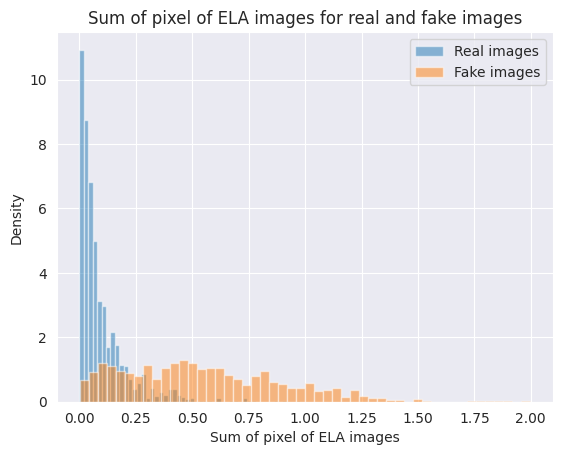

In [16]:
plt.hist(real['sum_of_pixel'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['sum_of_pixel'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Sum of pixel of ELA images')
plt.ylabel('Density')
plt.title('Sum of pixel of ELA images for real and fake images')
plt.savefig('sum_of_pixel.png')
plt.show()

In [18]:
df[['label', 'colorfulness']].groupby('label').describe()

colorfulness                                                        \
             count       mean        std       min        25%        50%   
label                                                                      
0           1423.0  23.712042  11.946527  2.707372  14.961433  21.194239   
1           1323.0  30.428703  12.243773  5.120657  21.914994  28.957916   

                             
             75%        max  
label                        
0      30.347873  74.707864  
1      37.532287  89.818383

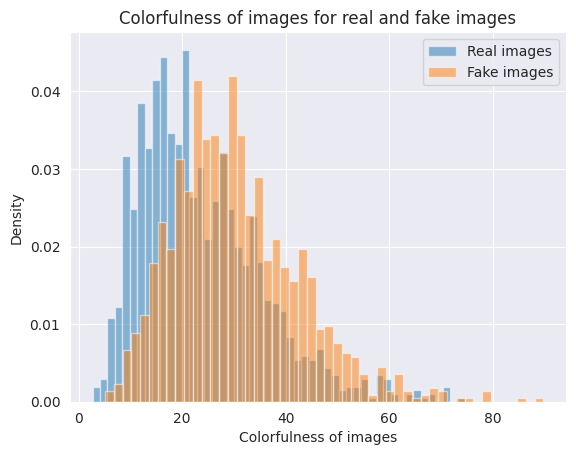

In [21]:
plt.hist(real['colorfulness'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['colorfulness'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Colorfulness of images')
plt.ylabel('Density')
plt.title('Colorfulness of images for real and fake images')
plt.show()

In [22]:
df[['label', 'regularity']].groupby('label').describe()

regularity                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0         1423.0  0.002729  0.003603  0.000071  0.001152  0.001902  0.003069   
1         1323.0  0.002441  0.006445  0.000108  0.000726  0.001265  0.002222   

                 
            max  
label            
0      0.052301  
1      0.149067

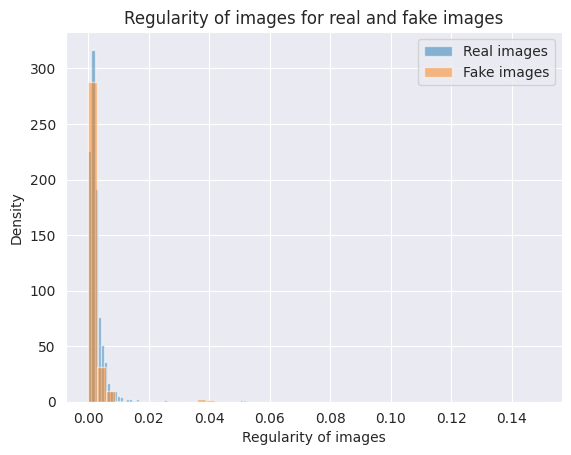

In [24]:
plt.hist(real['regularity'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['regularity'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Regularity of images')
plt.ylabel('Density')
plt.title('Regularity of images for real and fake images')
plt.show()

In [25]:
df[['label', 'roughness']].groupby('label').describe()

roughness                                                              \
          count      mean       std       min       25%       50%       75%   
label                                                                         
0        1423.0  0.022718  0.030159  0.000592  0.007475  0.014370  0.026854   
1        1323.0  0.005901  0.005305  0.000657  0.002779  0.004265  0.006966   

                 
            max  
label            
0      0.369428  
1      0.053685

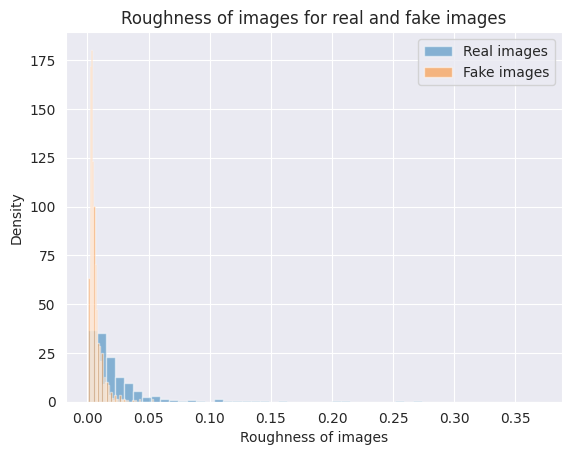

In [26]:
plt.hist(real['roughness'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['roughness'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Roughness of images')
plt.ylabel('Density')
plt.title('Roughness of images for real and fake images')
plt.show()

In [27]:
df[['label', 'noise_level']].groupby('label').describe()

noise_level                                                         \
            count       mean        std        min        25%        50%   
label                                                                      
0          1423.0  50.118686  11.776233  14.779695  41.987205  49.829225   
1          1323.0  56.137631   9.175334  21.320983  50.790856  56.287931   

                             
             75%        max  
label                        
0      58.165185  89.456470  
1      62.208574  87.307788

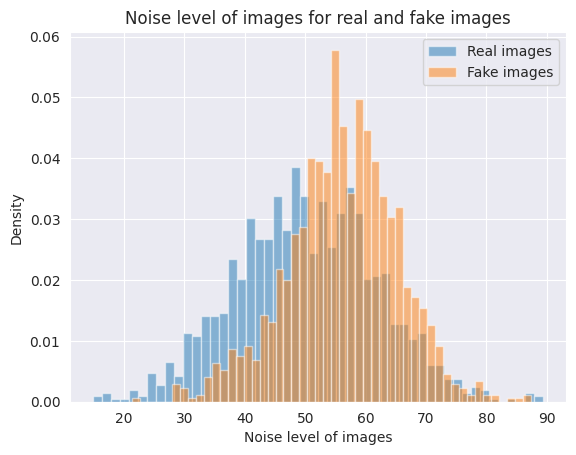

In [28]:
plt.hist(real['noise_level'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['noise_level'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Noise level of images')
plt.ylabel('Density')
plt.title('Noise level of images for real and fake images')
plt.show()

In [29]:
df[['label', 'cfa_metric']].groupby('label').describe()

cfa_metric                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0         1423.0  0.015362  0.028242  0.000003  0.000130  0.000392  0.023131   
1         1323.0  0.002597  0.009757  0.000010  0.000267  0.000533  0.001029   

                 
            max  
label            
0      0.172263  
1      0.135404

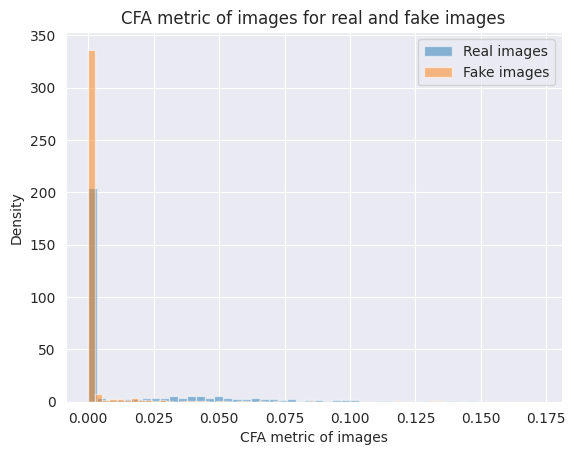

In [30]:
plt.hist(real['cfa_metric'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['cfa_metric'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('CFA metric of images')
plt.ylabel('Density')
plt.title('CFA metric of images for real and fake images')
plt.show()

In [33]:
df[['label', 'editing_artifacts']].groupby('label').describe()

editing_artifacts                                                        \
                  count       mean        std       min        25%        50%   
label                                                                           
0                1423.0  12.897748  11.581592  0.913737   5.578177   9.376328   
1                1323.0  30.426712  14.965871  3.119587  19.766937  28.507525   

                              
             75%         max  
label                         
0      15.767833   98.283553  
1      38.556600  100.157739

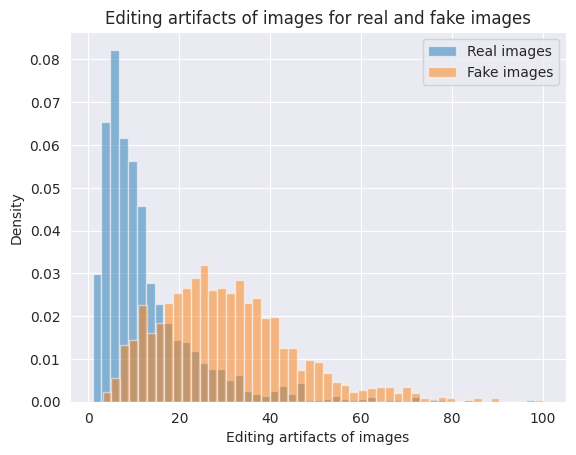

In [38]:
plt.hist(real['editing_artifacts'], bins=50, alpha=0.5, label='Real images', density=True)
plt.hist(fake['editing_artifacts'], bins=50, alpha=0.5, label='Fake images', density=True)
plt.legend(loc='upper right')
plt.xlabel('Editing artifacts of images')
plt.ylabel('Density')
plt.title('Editing artifacts of images for real and fake images')
plt.show()

In [37]:
# describe haralick features according to the label
df[['label', 'haralick_0', 'haralick_1', 'haralick_2', 'haralick_3', 'haralick_4', 'haralick_5', 'haralick_6', 'haralick_7', 'haralick_8', 'haralick_9', 'haralick_10', 'haralick_11', 'haralick_12']].groupby('label').describe()

haralick_0                                                              \
           count      mean       std       min       25%       50%       75%   
label                                                                          
0         1423.0  0.002567  0.003473  0.000063  0.001033  0.001736  0.002886   
1         1323.0  0.002240  0.006388  0.000090  0.000598  0.001067  0.001920   

                haralick_1              ... haralick_11           haralick_12  \
            max      count        mean  ...         75%       max       count   
label                                   ...                                     
0      0.054995     1423.0  146.155737  ...   -0.435682 -0.098326      1423.0   
1      0.146460     1323.0  368.444994  ...   -0.327242 -0.126750      1323.0   

                                                                             
           mean       std       min       25%       50%       75%       max  
label                                                                        
0      0.998552  0.005413  0.882121  0.999061  0.999623  0.999859  0.999992  
1      0.996614  0.005494  0.924201  0.996153  0.998325  0.999330  0.999954  

[2 rows x 104 columns]

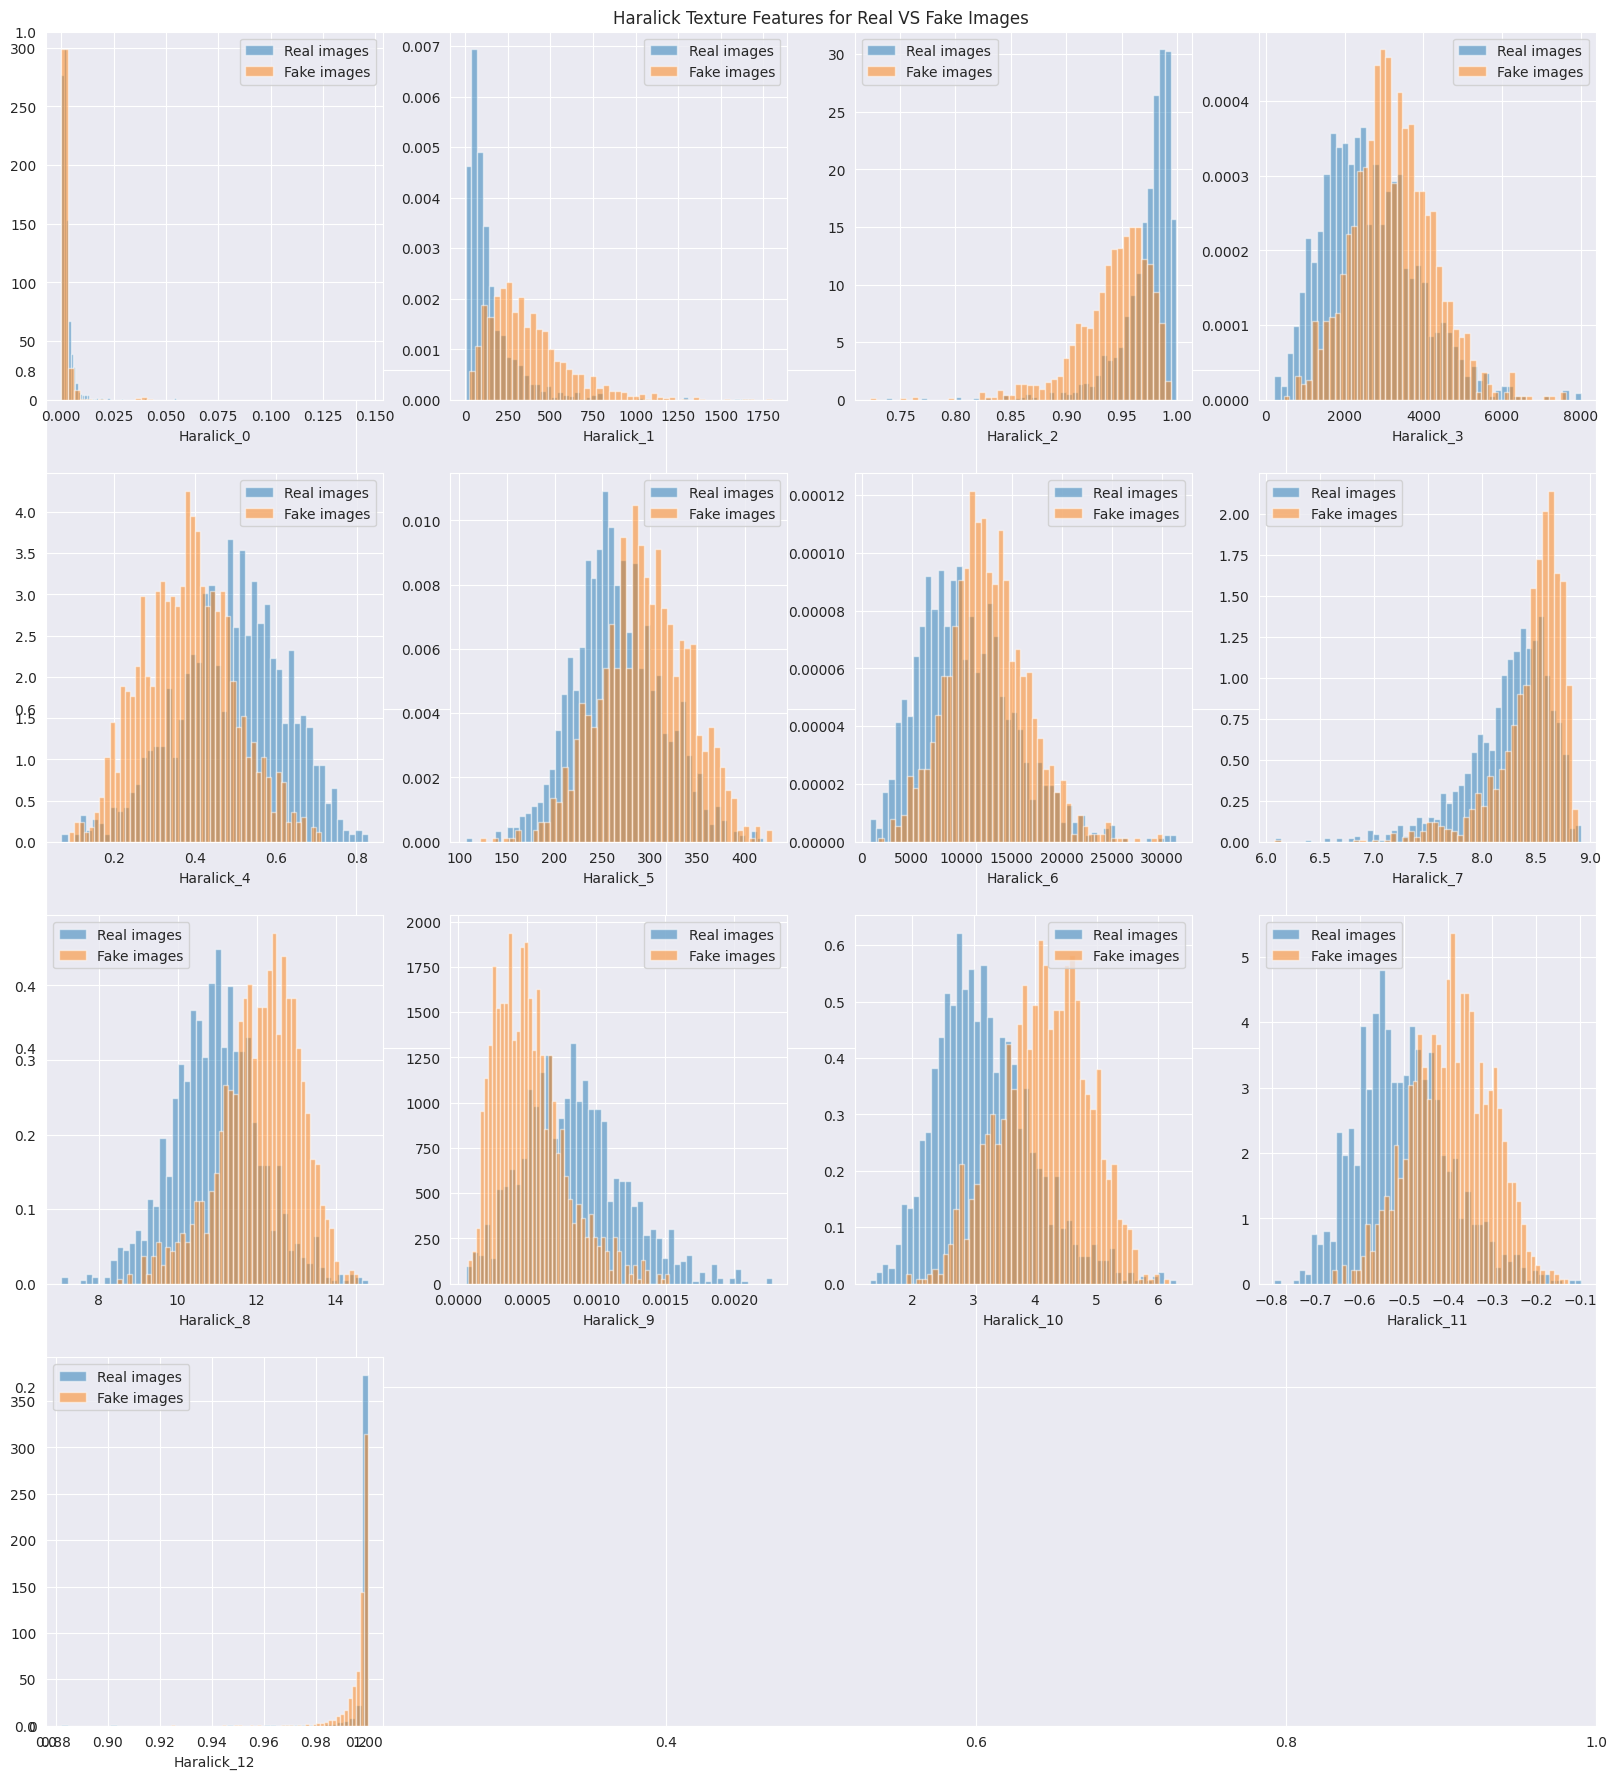

In [35]:
plt.figure(figsize=(20, 22))
plt.title("Haralick Texture Features for Real VS Fake Images")
for i in range(13):
    plt.subplot(4, 4, i+1)
    plt.hist(real[f'haralick_{i}'], bins=50, alpha=0.5, label='Real images', density=True)
    plt.hist(fake[f'haralick_{i}'], bins=50, alpha=0.5, label='Fake images', density=True)
    plt.xlabel(f"Haralick_{i}")
    plt.legend()

plt.savefig('haralick.png')
plt.show()